In [1]:
# importamos paquetes necesarios
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import linear_reset
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Taller 3
Por: Paola Andrea Fernández 

Con la serie que escogió para el taller 2 estime 5 modelos, y realice el proceso de Validación y pronostico con ellos. Escoja y justifique cual de los modelos estimados es el mejor.

En este ejercicio escogeré una serie de una acción que compone el SP500 a diferencia del taller 2 en el que escogí directamente el SP500, por esta razón haré el análisis completo desde la identificación de la serie.

## 1. Identificación
### 1.1 Evaluar estacionariedad
Dado que la no-estacionariedad de una serie genera problemas en la estimación de los parámetros, debemos de asegurarnos de usar una serie estacionaria. Para esto vamos a utilizar algunas pruebas estadisticas para asegurar la estacionariedad de la serie.

<AxesSubplot:title={'center':'Apple Inc'}, xlabel='Date'>

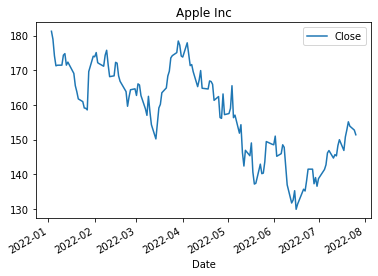

In [2]:
stock = yf.Ticker("AAPL")
prices = stock.history(start="2022-01-01",  end="2022-07-27")[['Close']]
prices.plot(title = 'Apple Inc')

### Pruebas de raíces unitarias
Prueba de Dickey-Fuller aumentada

In [3]:
def DF_test(series):
    result = adfuller(series, autolag="AIC")
    stat, p_value, _ ,_ ,crit_values,_ = result
    reject = 'Reject null hypothesis' if p_value < 0.05 else 'Failed to reject null hypothesis'
    conc = 'Time series is non-stationary' if reject == 'Failed to reject null hypothesis' else 'Time series is stationary'
    print("Null hypothesis: Time series is non-stationary \nStatistic: {} \nP-value: {} \n{} \n:: {}".format(stat, p_value, reject, conc))
DF_test(prices)

Null hypothesis: Time series is non-stationary 
Statistic: -2.0247040343217853 
P-value: 0.27584737465717485 
Failed to reject null hypothesis 
:: Time series is non-stationary


Prueba KPSS

In [4]:
def KPSS_test(series):
    result = kpss(series, regression="c", nlags="auto")
    stat, p_value, _  ,crit_values = result
    reject = 'Reject null hypothesis' if p_value < 0.05 else 'Failed to reject null hypothesis'
    conc = 'Time series is stationary' if reject == 'Failed to reject null hypothesis' else 'Time series is non-stationary'
    print("Null hypothesis: Time series is stationary \nStatistic: {} \nP-value: {} \n{} \n:: {}".format(stat, p_value, reject, conc))
KPSS_test(prices)

Null hypothesis: Time series is stationary 
Statistic: 1.2050216433434187 
P-value: 0.01 
Reject null hypothesis 
:: Time series is non-stationary


### 1.2 Transformación Box-Cox

In [5]:
boxcox_trans, lambda_maxlog, conf_lims = stats.boxcox(list(prices['Close'].values), alpha= 0.05)
print("Lambda that maximizes the log-likelihood function: {}\nConfidence limits for lambda: {}".format(lambda_maxlog, conf_lims))

Lambda that maximizes the log-likelihood function: 2.8529691574623772
Confidence limits for lambda: (0.6883123107142449, 5.066889371816806)


Como el cero no está contenido en los intervalos de confianza para lambda, entonces no haremos transformación de la serie. Dado que encontramos en las pruebas de raices unitarias que la serie es no estacionaria, vamos a diferenciarla y evaluar si la serie en diferencias ya es estacionaria para poder seguir con el proceso de identificación

<AxesSubplot:title={'center':'Diff of Apple'}, xlabel='Date'>

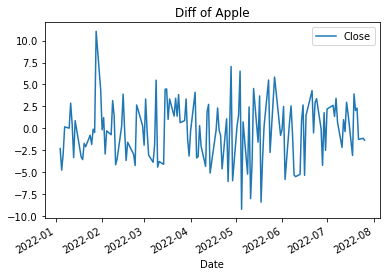

In [6]:
diff_prices = prices.diff().dropna()
diff_prices.plot(title = 'Diff of Apple')

In [7]:
DF_test(diff_prices)

Null hypothesis: Time series is non-stationary 
Statistic: -11.591533121411635 
P-value: 2.7843246103425507e-21 
Reject null hypothesis 
:: Time series is stationary


In [8]:
KPSS_test(diff_prices)

Null hypothesis: Time series is stationary 
Statistic: 0.08996823312672222 
P-value: 0.1 
Failed to reject null hypothesis 
:: Time series is stationary


### 1.3 Identificación de la serie estacionaria
Ya que tenemos la serie estacionaria (débil) vamos a esoger un modelo adecuado. Para esto utilizaremos las funciones de autocorrelacion y autocorrelacion parcial.

FACE

In [9]:
acf_values = acf(diff_prices)
acf_values

array([ 1.        ,  0.01068732, -0.0751091 , -0.03006712,  0.12376679,
       -0.01003134, -0.09703776,  0.06326516, -0.15105013,  0.0311507 ,
       -0.10312942,  0.10218068, -0.08700508,  0.03611422, -0.0112453 ,
       -0.09704089, -0.0517394 , -0.02961834,  0.02622605,  0.01597156,
        0.12252277,  0.02171186, -0.0963578 , -0.05701028,  0.06758787,
       -0.00397502, -0.09690114,  0.01811124, -0.05674131, -0.00815826,
       -0.02648066,  0.00100644,  0.05180155,  0.05575501,  0.11316292,
       -0.01258293, -0.01517806, -0.0810526 , -0.01887011,  0.03329643,
       -0.06215049])

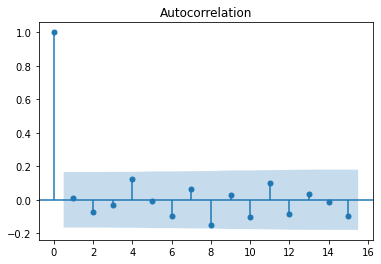

In [10]:
plot_acf(diff_prices, lags=15);

 Comportamiento similar al de un MA(1)

FACPE

In [11]:
pacf_values = pacf(diff_prices)
pacf_values

array([ 1.        ,  0.0107642 , -0.07632235, -0.02919459,  0.12305419,
       -0.01813283, -0.08594873,  0.07727654, -0.19771712,  0.05248215,
       -0.11763519,  0.09999943, -0.08977841,  0.0661907 , -0.04649913,
       -0.10288818, -0.09534977, -0.00994384, -0.0637373 ,  0.12548533,
        0.08821152,  0.0789443 , -0.16761312, -0.06424421, -0.02226557,
       -0.03259743, -0.07671817,  0.08628445, -0.12502631,  0.0549312 ,
       -0.10639189, -0.04158205,  0.03244384,  0.11504414,  0.15555585,
        0.07891336, -0.05749485, -0.14821085, -0.22945824,  0.05393509,
       -0.14962927])

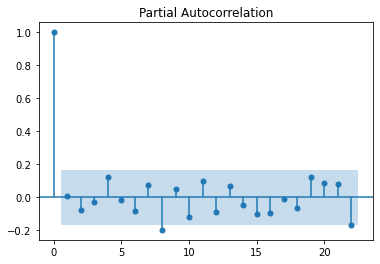

In [12]:
plot_pacf(diff_prices);

Comportamiento similar al de un AR(1)

Entonces tenemos en el FACE un comportamiento similar al de un MA(1) y en el  FACPE un comportamiento similar al de un AR(1).

Por lo cual lo más probable es que tengamos un modelo ARIMA(1,1,1). Sin embargo, vamos a estimar 5 modelos diferentes y evaluar cual es el mejor de ellos.

## 2. Estimación
Se evaluan 5 posibles modelos presentados a continuación. La estimación de los parámetros se realiza con el paquete ARIMA de statsmodels (https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMA.html)
### 2.1 Modelo 1: ARMA(1,1)

In [13]:
arima_model_1 = ARIMA(prices, order=(1,1,1))
model_1 = arima_model_1.fit(disp=0)
print(model_1.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  140
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -367.292
Method:                       css-mle   S.D. of innovations              3.314
Date:                Tue, 09 Aug 2022   AIC                            742.584
Time:                        15:00:12   BIC                            754.350
Sample:                             1   HQIC                           747.365
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.2362      0.074     -3.182      0.001      -0.382      -0.091
ar.L1.D.Close     0.9278      0.036     25.652      0.000       0.857       0.999
ma.L1.D.Close    -0.9999      0.019    -

### 2.2 Modelo 2: AR(1)

In [14]:
arima_model_2 = ARIMA(prices, order=(1,1,0))
model_2 = arima_model_2.fit(disp=0)
print(model_2.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  140
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -368.984
Method:                       css-mle   S.D. of innovations              3.376
Date:                Tue, 09 Aug 2022   AIC                            743.969
Time:                        15:00:12   BIC                            752.794
Sample:                             1   HQIC                           747.555
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.2136      0.288     -0.741      0.459      -0.779       0.352
ar.L1.D.Close     0.0106      0.084      0.126      0.900      -0.155       0.176
                                    Root

### 2.3 Modelo 3: MA(1)

In [15]:
arima_model_3 = ARIMA(prices, order=(0,1,1))
model_3 = arima_model_3.fit(disp=0)
print(model_3.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  140
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -368.983
Method:                       css-mle   S.D. of innovations              3.376
Date:                Tue, 09 Aug 2022   AIC                            743.966
Time:                        15:00:12   BIC                            752.791
Sample:                             1   HQIC                           747.552
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.2136      0.289     -0.740      0.460      -0.780       0.353
ma.L1.D.Close     0.0125      0.091      0.137      0.891      -0.166       0.191
                                    Root

### 2.4 Modelo 4: ARMA(2,2)

In [16]:
arima_model_4 = ARIMA(prices, order=(2,1,2))
model_4 = arima_model_4.fit(disp=0)
print(model_4.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  140
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -368.030
Method:                       css-mle   S.D. of innovations              3.326
Date:                Tue, 09 Aug 2022   AIC                            748.061
Time:                        15:00:12   BIC                            765.711
Sample:                             1   HQIC                           755.233
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.2110      0.280     -0.754      0.451      -0.760       0.338
ar.L1.D.Close     1.0784      0.020     54.258      0.000       1.039       1.117
ar.L2.D.Close    -0.9996      0.005   -2

### 2.5 Modelo 5: ARMA(2,1)

In [17]:
arima_model_5 = ARIMA(prices, order=(2,1,1))
model_5 = arima_model_5.fit(disp=0)
print(model_5.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  140
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -368.571
Method:                       css-mle   S.D. of innovations              3.366
Date:                Tue, 09 Aug 2022   AIC                            747.143
Time:                        15:00:12   BIC                            761.851
Sample:                             1   HQIC                           753.120
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.2085      0.265     -0.786      0.432      -0.728       0.311
ar.L1.D.Close     0.1068      0.560      0.191      0.849      -0.991       1.205
ar.L2.D.Close    -0.0775      0.084     

## 3. Validación
Con los 5 modelos planteados anteriormente, vamos a validar cuál de ellos es el más adecuado mirando varios supuestos/requisitos que se deben cumplir.

### 3.1 Ruido blanco
Bajo una especificación correcta del modelo, se esperaría que los residuales fueran una serie de ruidos blanco. Para que los residuales estimados sean ruido blanco, entonces se debería cumplir que los coeficientes de autocorrelacion y autocorrelación parcial no sean estadísticamente diferentes de cero. 
Para testear esto, utilizamos los test de Box-Pierce (1970) y Ljung-Box (1978), cuya hipótesis nula es la no autocorrelación de los residuales $\hat{\epsilon}_t$

In [18]:
def lb_bp_test(residuals):
    result = sm.stats.acorr_ljungbox(residuals, boxpierce= True, lags=[10], return_df=True)
    lb_stat, lb_value, bp_stat  ,bp_value = result.values[0]
    print("--------------------------------------------------------")
    print("Ljung-Box test")
    print("--------------------------------------------------------")
    reject = 'Reject null hypothesis' if lb_value < 0.05 else 'Failed to reject null hypothesis'
    conc = 'No autocorrelation in residuals' if reject == 'Failed to reject null hypothesis' else 'Autocorrelation in residuals'
    print("Null hypothesis: No autocorrelation in residuals \nStatistic: {} \nP-value: {} \n{} \n:: {}".format(lb_stat, lb_value, reject, conc))
    print("--------------------------------------------------------")
    print("Box-Pierces test")
    print("--------------------------------------------------------")
    reject = 'Reject null hypothesis' if bp_value < 0.05 else 'Failed to reject null hypothesis'
    conc = 'No autocorrelation in residuals' if reject == 'Failed to reject null hypothesis' else 'Autocorrelation in residuals'
    print("Null hypothesis: No autocorrelation in residuals \nStatistic: {} \nP-value: {} \n{} \n:: {}".format(bp_stat, bp_value, reject, conc))

Tests para el modelo 1:

Text(0.5, 1.0, 'Residuales estimados modelo 1')

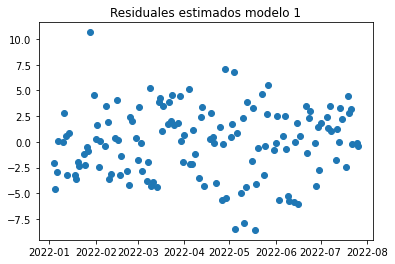

In [19]:
plt.scatter(x = model_1.resid.index, y = model_1.resid.values)
plt.title('Residuales estimados modelo 1')

In [20]:
lb_bp_test(model_1.resid)

--------------------------------------------------------
Ljung-Box test
--------------------------------------------------------
Null hypothesis: No autocorrelation in residuals 
Statistic: 9.497670756997517 
P-value: 0.48561129941273984 
Failed to reject null hypothesis 
:: No autocorrelation in residuals
--------------------------------------------------------
Box-Pierces test
--------------------------------------------------------
Null hypothesis: No autocorrelation in residuals 
Statistic: 8.939748189617378 
P-value: 0.5378311117985769 
Failed to reject null hypothesis 
:: No autocorrelation in residuals


Tests para el modelo 2:

Text(0.5, 1.0, 'Residuales estimados modelo 2')

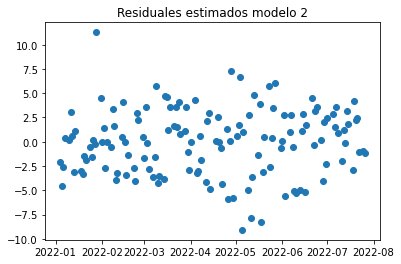

In [21]:
plt.scatter(x = model_2.resid.index, y = model_2.resid.values)
plt.title('Residuales estimados modelo 2')

In [22]:
lb_bp_test(model_2.resid)

--------------------------------------------------------
Ljung-Box test
--------------------------------------------------------
Null hypothesis: No autocorrelation in residuals 
Statistic: 10.610320693569054 
P-value: 0.38867189808985636 
Failed to reject null hypothesis 
:: No autocorrelation in residuals
--------------------------------------------------------
Box-Pierces test
--------------------------------------------------------
Null hypothesis: No autocorrelation in residuals 
Statistic: 9.965641029765134 
P-value: 0.4435128848936254 
Failed to reject null hypothesis 
:: No autocorrelation in residuals


Tests para el modelo 3:

Text(0.5, 1.0, 'Residuales estimados modelo 3')

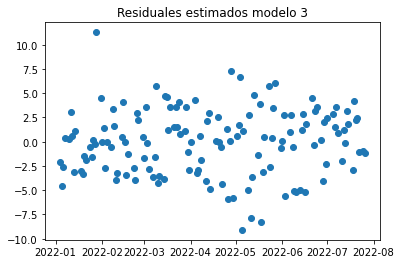

In [23]:
plt.scatter(x = model_3.resid.index, y = model_3.resid.values)
plt.title('Residuales estimados modelo 3')

In [24]:
lb_bp_test(model_3.resid)

--------------------------------------------------------
Ljung-Box test
--------------------------------------------------------
Null hypothesis: No autocorrelation in residuals 
Statistic: 10.64585491238908 
P-value: 0.3857662321403954 
Failed to reject null hypothesis 
:: No autocorrelation in residuals
--------------------------------------------------------
Box-Pierces test
--------------------------------------------------------
Null hypothesis: No autocorrelation in residuals 
Statistic: 9.998513965501076 
P-value: 0.44062367003333613 
Failed to reject null hypothesis 
:: No autocorrelation in residuals


Tests para el modelo 4:

Text(0.5, 1.0, 'Residuales estimados modelo 4')

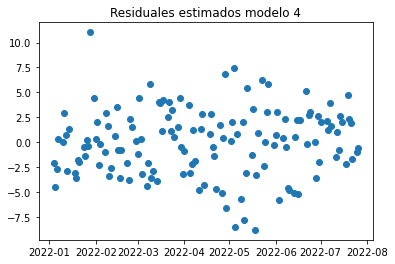

In [25]:
plt.scatter(x = model_4.resid.index, y = model_4.resid.values)
plt.title('Residuales estimados modelo 4')

In [26]:
lb_bp_test(model_4.resid)

--------------------------------------------------------
Ljung-Box test
--------------------------------------------------------
Null hypothesis: No autocorrelation in residuals 
Statistic: 11.197886825206522 
P-value: 0.3423101437023142 
Failed to reject null hypothesis 
:: No autocorrelation in residuals
--------------------------------------------------------
Box-Pierces test
--------------------------------------------------------
Null hypothesis: No autocorrelation in residuals 
Statistic: 10.532842556728909 
P-value: 0.39505138505894555 
Failed to reject null hypothesis 
:: No autocorrelation in residuals


Tests para el modelo 5:

Text(0.5, 1.0, 'Residuales estimados modelo 5')

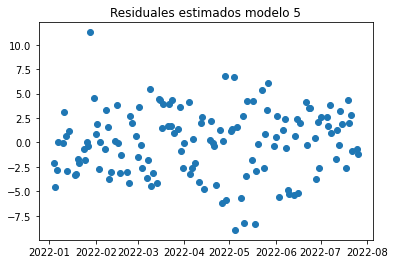

In [27]:
plt.scatter(x = model_5.resid.index, y = model_5.resid.values)
plt.title('Residuales estimados modelo 5')

In [28]:
lb_bp_test(model_5.resid)

--------------------------------------------------------
Ljung-Box test
--------------------------------------------------------
Null hypothesis: No autocorrelation in residuals 
Statistic: 11.135801098570889 
P-value: 0.34703623543956713 
Failed to reject null hypothesis 
:: No autocorrelation in residuals
--------------------------------------------------------
Box-Pierces test
--------------------------------------------------------
Null hypothesis: No autocorrelation in residuals 
Statistic: 10.399862531891129 
P-value: 0.4061395532813953 
Failed to reject null hypothesis 
:: No autocorrelation in residuals


En todas las gráficas de los residuales de los 5 modelos observamos que no hay outliers evidentes que puedan estar siendo ocasionadas por choques exógenos sobre las variables. Tampoco se observa que la dispersión de los errores cambie en el tiempo (no hay heterocedasticidad). 
Además los resultados de las dos pruebas nos indican que en todos los modelos no hay autocorrelación en los residuales.
Por esta razón concluimos que todos los modelos cumplen la condición de ruido blanco

### 3.2 Estacionariedad y estabilidad
- Para comprobar si el modelo estimado es estacionario factorizamos el polinomio de la parte autorregresiva y si existe una raiz cerca a 1 es un indicio de que el modelo es no estacionario.
- Para comprobar si el modelo estimado es invertible se efectúa la factorización de las raices MA y si existe una raiz cercana a 1 es un indicio de que el modelo es no invertible.

In [29]:
def get_roots(model):
    try:
        ar_roots = model.arroots[0]
        print("-----------------------------")
        print("AR roots")
        print("-----------------------------")
        print(ar_roots)
    except:
        pass
    try:
        ma_roots = model.maroots[0]
        print("-----------------------------")
        print("MA roots")
        print("-----------------------------")
        print(ma_roots)
    except:
        pass

Modelo 1:

Posiblemente no estacionario y no invertible

In [30]:
get_roots(model_1)

-----------------------------
AR roots
-----------------------------
1.0778226703187832
-----------------------------
MA roots
-----------------------------
1.0000743722185705


Modelo 2:

Posiblemente estacionario

In [31]:
get_roots(model_2)

-----------------------------
AR roots
-----------------------------
93.9015958505544


Modelo 3:

Posiblemente invertible

In [32]:
get_roots(model_3)

-----------------------------
MA roots
-----------------------------
-79.96982517831408


Modelo 4:

Posiblemente estacionario e invertible

In [33]:
get_roots(model_4)

-----------------------------
AR roots
-----------------------------
(0.5394101353546339-0.8422909484418025j)
-----------------------------
MA roots
-----------------------------
(0.5414230524717814-0.840750331089127j)


Modelo 5:

Posiblemente estacionario e invertible

In [34]:
get_roots(model_5)

-----------------------------
AR roots
-----------------------------
(0.6885492610498112-3.524698981793453j)
-----------------------------
MA roots
-----------------------------
10.371509787330947


### 3.3 Significancia y correlación
Otra característica que deseamos en el modelo es que los coeficientes sean significativos y que no estén correlacionados. Lo anterior dado que incluir parámetros no significativos incrementa la incertidumbre en la predicción del modelo.

En el modelo 1 todos los coeficientes son significativos, no hay problemas de multicolinealidad

In [35]:
model_1.pvalues

const             1.460175e-03
ar.L1.D.Close    3.968237e-145
ma.L1.D.Close     0.000000e+00
dtype: float64

In [36]:
model_1.cov_params()

,const,ar.L1.D.Close,ma.L1.D.Close
const,5.509795e-03,2.020917e-04,7.224811e-07
ar.L1.D.Close,2.020917e-04,1.308118e-03,-9.428719e-07
ma.L1.D.Close,7.224811e-07,-9.428719e-07,3.451127e-04


En el modelo 2 ningun coeficiente es significativo, no hay problemas de multicolinealidad

In [37]:
model_2.pvalues

const            0.458856
ar.L1.D.Close    0.899544
dtype: float64

In [38]:
model_2.cov_params()

,const,ar.L1.D.Close
const,0.083158,-0.000167
ar.L1.D.Close,-0.000167,0.007117


En el modelo 3 ningun coeficiente es significativo, no hay problemas de multicolinealidad

In [39]:
model_3.pvalues

const            0.459547
ma.L1.D.Close    0.891090
dtype: float64

In [40]:
model_3.cov_params()

,const,ma.L1.D.Close
const,0.083442,-0.000184
ma.L1.D.Close,-0.000184,0.008340


En el modelo 4 todos los coeficientes son significativos

In [41]:
model_4.pvalues

const             4.508787e-01
ar.L1.D.Close     0.000000e+00
ar.L2.D.Close     0.000000e+00
ma.L1.D.Close    6.460514e-119
ma.L2.D.Close     4.644279e-95
dtype: float64

In [42]:
model_4.cov_params()

,const,ar.L1.D.Close,ar.L2.D.Close,ma.L1.D.Close,ma.L2.D.Close
const,7.835280e-02,-9.644652e-05,-2.540976e-05,0.000235,8.948021e-08
ar.L1.D.Close,-9.644652e-05,3.950133e-04,3.159283e-05,-0.000560,-1.276872e-07
ar.L2.D.Close,-2.540976e-05,3.159283e-05,2.453717e-05,-0.000168,-8.531326e-08
ma.L1.D.Close,2.349054e-04,-5.596955e-04,-1.683324e-04,0.002181,-1.264696e-03
ma.L2.D.Close,8.948020e-08,-1.276872e-07,-8.531326e-08,-0.001265,2.336968e-03


En el modelo 5 ningun coeficiente es significativo

In [43]:
model_5.pvalues

const            0.431701
ar.L1.D.Close    0.848855
ar.L2.D.Close    0.358699
ma.L1.D.Close    0.862672
dtype: float64

In [44]:
model_5.cov_params()

,const,ar.L1.D.Close,ar.L2.D.Close,ma.L1.D.Close
const,0.070307,0.001951,-0.000433,-0.002087
ar.L1.D.Close,0.001951,0.313877,-0.001841,-0.308747
ar.L2.D.Close,-0.000433,-0.001841,0.007136,0.001194
ma.L1.D.Close,-0.002087,-0.308747,0.001194,0.310711


### 3.4 Bondad de ajuste
Finalmente veremos diferentes criterios para bondad de ajuste del modelo.
Usaremos los siguientes criterios basados en ajuste muestrales:
- AIC (Akaike information criterion)
- BIC (Bayesian information criterion)
- HIQC (Hannan-Quinn information criterion)

In [45]:
pd.DataFrame({
    'Model' : ['Model 1','Model 2','Model 3','Model 4','Model 5' ],
    'AIC': [model_1.aic, model_2.aic,model_3.aic,model_4.aic,model_5.aic],
    'BIC': [model_1.bic, model_2.bic,model_3.bic,model_4.bic,model_5.bic],
    'HIQC': [model_1.hqic,model_2.hqic,model_3.hqic,model_4.hqic,model_5.hqic ]
    }).set_index('Model')

,AIC,BIC,HIQC
Model,,,
Model 1,742.583636,754.350206,747.365218
Model 2,743.968686,752.793613,747.554873
Model 3,743.965899,752.790826,747.552085
Model 4,748.060887,765.710742,755.233260
Model 5,747.142860,761.851072,753.119838


De acuerdo con estos criterios los mejores candidatos son los modelos 1, 2 y 3. Sin embargo, los tres modelos presentan algunos problemas. Vimos por ejemplo que en los modelos 2 y 3 los coeficientes no eran significativos y que el modelo 1 tenía raíces muy cercanas a 1. 

## 4. Predicción
Ahora que tenemos tres candidatos, vamos a evaluar su capacidad predictiva. Para esto, vamos a dividir la muestra en train y test y vamos a evaluar de los tres modelos cual es el que tiene mejor capacidad para predecir. Vamos a entrenar los tres modelos con diferentes test sets que van incorporando cada vez mas datos y predecimos el dato siguiente (rolling cross validation). Calculamos el error absoluto y vemos en promedio cual tiene el menor error

In [46]:
def rolling_cross_val(prices, window = 30):
    resultado = pd.DataFrame()
    for h in range(window,len(prices),1):
        train = prices[:h]
        test = prices.iloc[h,:]
        model_1_train = ARIMA(train, order=(1,1,1)).fit(disp=0)
        model_2_train = ARIMA(train, order=(1,1,0)).fit(disp=0)
        model_3_train = ARIMA(train, order=(0,1,1)).fit(disp=0)
        error_1 = model_1_train.forecast(1)[0] - test.values
        error_2 = model_2_train.forecast(1)[0] - test.values
        error_3 = model_3_train.forecast(1)[0] - test.values
        resultado.loc[h,'Error modelo 1'] = np.abs(error_1[0])
        resultado.loc[h,'Error modelo 2'] = np.abs(error_2[0])
        resultado.loc[h,'Error modelo 3'] = np.abs(error_3[0])
    return resultado

In [47]:
res = rolling_cross_val(prices, 50)

In [48]:
res.describe()

,Error modelo 1,Error modelo 2,Error modelo 3
count,91.000000,91.000000,91.000000
mean,2.814345,2.913153,2.925239
std,2.177152,2.071591,2.085230
min,0.000984,0.107214,0.109622
25%,0.984648,1.172550,1.240227
50%,2.618993,2.573315,2.573903
75%,4.013938,4.078520,3.983666
max,11.248099,9.831978,10.111505


Vemos que el modelo 1 tiene el menor error absoluto promedio, con lo cual, teniendo en cuenta todo el análisis anterior, podemos escoger este  modelo como el elegido, pero haciendo enfasis en que podría tener problemas de estacionariedad e invertibilidad. Gráficamente así se ven los valores de este modelo comparados con la serie real:

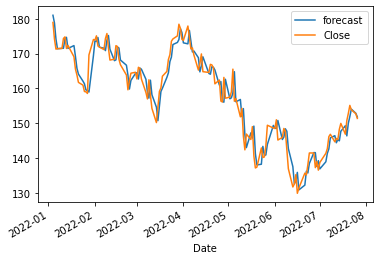

In [49]:
model_1.plot_predict(dynamic=False)
plt.show()